<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>09. OIL and GAS Catboost classifier</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Binarización de variable delta_WHP](#23)<br>
    2.4. [Separación de OIL y GAS](#24)<br>
3. [Modelo OIL](#3)<br>
    3.1. [Separación en train y test OIL](#31)<br>
    3.2. [Confección pipeline modelo OIL](#32)<br>
    3.3. [Optimización de hiperparámetros modelo OIL](#33)<br>
    3.4. [Entrenamiento del modelo OIL](#34)<br>
    3.5. [Mejores Hiperparámetros modelo OIL](#35)<br>
    3.6. [Estimaciones de train y test modelo OIL](#36)<br>
    3.7. [Cálculo de precision modelo OIL](#37)<br>
4. [Modelo GAS](#4)<br>
    4.1. [Separación en train y test GAS](#41)<br>
    4.2. [Confección pipeline modelo GAS](#42)<br>
    4.3. [Optimización de hiperparámetros modelo GAS](#43)<br>
    4.4. [Entrenamiento del modelo GAS](#44)<br>
    4.5. [Mejores Hiperparámetros modelo GAS](#45)<br>
    4.6. [Estimaciones de train y test modelo GAS](#46)<br>
    4.7. [Cálculo de precision modelo GAS](#47)<br>
5. [Evaluación del modelo](#5)<br>
    5.1. [Concatenación de estimaciones de OIL y GAS](#51)<br>
    5.1. [Cálculo de métricas](#51)<br>
    5.2. [Matriz de confusión](#52)<br>
    5.3. [ROC Curve](#53)<br>
    5.4. [Precision-Recall curve](#54)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier

import chardet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
20081,Pozo 373-Pozo 325-21,Campo F,OIL,PAD-86,Pozo 373,21,Pozo 325,362.850641,362.816471,-4.979545,82.411739,0.0,NO,111.5,7.7,Cerrado
14038,Pozo 484-Pozo 137-15,Campo C,GAS,PAD-26,Pozo 484,15,Pozo 137,810.416374,808.772956,51.584932,78.015926,4.0,NO,250.6,0.0,Abierto
21283,Pozo 445-Pozo 452-9,Campo I,GAS,PAD-95,Pozo 445,9,Pozo 452,257.315614,257.312575,1.250657,96.877840,0.0,NO,170.3,2.6,Cerrado
24122,Pozo 204-Pozo 175-14,Campo D,OIL,PAD-35,Pozo 204,14,Pozo 175,158.310323,153.286300,39.566000,262.761668,0.0,NO,337.1,0.6,Cerrado
5773,Pozo 317-Pozo 331-18,Campo E,OIL,PAD-72,Pozo 317,18,Pozo 331,949.004155,948.866196,16.181103,128.221204,0.0,NO,44.0,0.0,Abierto


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Binarización de variable delta_WHP

In [ ]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="24"></a> <br>
### 2.4. Separación de OIL y GAS
**Se dividen en un dataframe las instancias correspondientes a OIL y en otro las correspondientes a GAS**

In [ ]:
# dataframe con instancias correspondientes a OIL
df_oil = df[df.FLUIDO == "OIL"]
print("Cantidad de intancias de OIL = ", df_oil.shape[0])

# dataframe con instancias correspondientes a GAS
df_gas = df[df.FLUIDO == "GAS"]
print("Cantidad de instancias de GAS = ", df_gas.shape[0])

Cantidad de intancias de OIL =  19974
Cantidad de instancias de GAS =  6204


***
<a id="#3"></a> <br>
## 3. Modelo OIL

<a id="31"></a> <br>
### 3.1. Separación en train y test OIL

In [ ]:
# Selección de variable target
y_oil = df_oil.delta_WHP_binarized
# Selección de features
X_oil = df_oil.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X_oil, y_oil, test_size = 0.25,  stratify= y_oil, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train OIL \n", X_train_oil.shape[0])
print("Instancias de test OIL \n", X_test_oil.shape[0])

Instancias de train OIL 
 14980
Instancias de test OIL 
 4994


<a id="32"></a> <br>
### 3.2. Confección pipeline OIL

In [ ]:
# Instanciado de estimador
catboost_class = CatBoostClassifier(random_state = 45)

# Instanciado de pipeline
pipe_oil = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("catboost_class", catboost_class)])

<a id="33"></a> <br>
### 3.3. Optimización de hiperparámetros modelo OIL

In [ ]:
# Optimización de hiperparámetros del modelo oil con grid search y cross validation

kfolds=StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

params_grid_oil = { 
                 "catboost_class__learning_rate" : [0.001, 0.01, 0.1],
                 "catboost_class__n_estimators" : [10, 100, 250],
                 "catboost_class__max_depth" : [5, 50, 80]
               }

model_oil = GridSearchCV (pipe_oil, params_grid_oil,cv=kfolds, n_jobs = -1, scoring = "recall", refit = True)

<a id="34"></a> <br>
### 3.4. Entrenamiento del modelo OIL

In [ ]:
# Entrenamiento del model_oil
model_oil.fit(X_train_oil, y_train_oil)

0:	learn: 0.5839290	total: 63.3ms	remaining: 15.8s
1:	learn: 0.4956523	total: 70ms	remaining: 8.68s
2:	learn: 0.4283342	total: 75.1ms	remaining: 6.18s
3:	learn: 0.3801006	total: 80.9ms	remaining: 4.98s
4:	learn: 0.3444038	total: 87.7ms	remaining: 4.3s
5:	learn: 0.3179539	total: 92.8ms	remaining: 3.77s
6:	learn: 0.2978694	total: 98.5ms	remaining: 3.42s
7:	learn: 0.2829665	total: 104ms	remaining: 3.16s
8:	learn: 0.2702036	total: 110ms	remaining: 2.94s
9:	learn: 0.2609874	total: 116ms	remaining: 2.79s
10:	learn: 0.2538666	total: 124ms	remaining: 2.69s
11:	learn: 0.2464367	total: 146ms	remaining: 2.89s
12:	learn: 0.2408066	total: 153ms	remaining: 2.78s
13:	learn: 0.2356294	total: 160ms	remaining: 2.69s
14:	learn: 0.2321044	total: 166ms	remaining: 2.6s
15:	learn: 0.2293456	total: 172ms	remaining: 2.52s
16:	learn: 0.2257882	total: 181ms	remaining: 2.48s
17:	learn: 0.2233916	total: 187ms	remaining: 2.41s
18:	learn: 0.2206216	total: 192ms	remaining: 2.34s
19:	learn: 0.2189931	total: 198ms	rema

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO',
                                                               'delta_WHP'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                              

<a id="35"></a> <br>
### 3.5. Mejores hiperparámetros modelo OIL

In [ ]:
# Mejores hiperparámetros del model_oil obtenidos por cross validation y grid search

model_oil.best_params_

{'catboost_class__learning_rate': 0.1,
 'catboost_class__max_depth': 5,
 'catboost_class__n_estimators': 250}

<a id="36"></a> <br>
### 3.6. Estimaciones de train y test modelo OIL

In [ ]:
# Estimación en train model_oil
pred_oil_train = model_oil.predict(X_train_oil)
pred_proba_oil_train = model_oil.predict_proba(X_train_oil)
# Estimación en test model_oil
pred_oil_test =  model_oil.predict(X_test_oil)
pred_proba_oil_test = model_oil.predict_proba(X_test_oil)

<a id="37"></a> <br>
### 3.7. Cálculo de precision modelo oil

In [ ]:
print("Precision train model_oil = ", precision_score(y_train_oil, pred_oil_train))
print("Precision test mode_oil = ", precision_score(y_test_oil, pred_oil_test))

Precision train model_oil =  0.9037603569152326
Precision test mode_oil =  0.8410852713178295


***
<a id="#4"></a> <br>
## 4. Modelo GAS

<a id="41"></a> <br>
### 4.1. Separación en train y test GAS

In [ ]:
# Selección de variable target
y_gas = df_gas.delta_WHP_binarized
# Selección de features
X_gas = df_gas.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size = 0.25,  stratify= y_gas, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train GAS \n", X_train_gas.shape[0])
print("Instancias de test GAS \n", X_test_gas.shape[0])

Instancias de train GAS 
 4653
Instancias de test GAS 
 1551


<a id="42"></a> <br>
### 4.2. Confección pipeline GAS

In [ ]:
# Instanciado de estimador
catboost_class = CatBoostClassifier(random_state = 45)

# Instanciado de pipeline
pipe_gas = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("catboost_class", catboost_class)])

<a id="43"></a> <br>
### 4.3. Optimización de hiperparámetros modelo GAS

In [ ]:
# Optimización de hiperparámetros del modelo gas con grid search y cross validation

kfolds=StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

params_grid_gas = { 
                 "catboost_class__learning_rate" : [0.001, 0.01, 0.1],
                 "catboost_class__n_estimators" : [10, 100, 250],
                 "catboost_class__max_depth" : [5, 50, 80]
               }

model_gas = GridSearchCV (pipe_gas, params_grid_gas,cv=kfolds, n_jobs = -1, scoring = "recall", refit = True)

<a id="44"></a> <br>
### 4.4. Entrenamiento del modelo GAS

In [ ]:
# Entrenamiento del model_gas
model_gas.fit(X_train_oil, y_train_oil)

0:	learn: 0.5839290	total: 7.08ms	remaining: 1.76s
1:	learn: 0.4956523	total: 15ms	remaining: 1.86s
2:	learn: 0.4283342	total: 21.1ms	remaining: 1.73s
3:	learn: 0.3801006	total: 27.5ms	remaining: 1.69s
4:	learn: 0.3444038	total: 33.7ms	remaining: 1.65s
5:	learn: 0.3179539	total: 40.1ms	remaining: 1.63s
6:	learn: 0.2978694	total: 45.8ms	remaining: 1.59s
7:	learn: 0.2829665	total: 64.3ms	remaining: 1.94s
8:	learn: 0.2702036	total: 70ms	remaining: 1.88s
9:	learn: 0.2609874	total: 78.9ms	remaining: 1.89s
10:	learn: 0.2538666	total: 92.9ms	remaining: 2.02s
11:	learn: 0.2464367	total: 105ms	remaining: 2.08s
12:	learn: 0.2408066	total: 113ms	remaining: 2.06s
13:	learn: 0.2356294	total: 134ms	remaining: 2.27s
14:	learn: 0.2321044	total: 142ms	remaining: 2.23s
15:	learn: 0.2293456	total: 153ms	remaining: 2.23s
16:	learn: 0.2257882	total: 158ms	remaining: 2.17s
17:	learn: 0.2233916	total: 164ms	remaining: 2.12s
18:	learn: 0.2206216	total: 170ms	remaining: 2.07s
19:	learn: 0.2189931	total: 176ms	

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO',
                                                               'delta_WHP'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                              

<a id="45"></a> <br>
### 4.5. Mejores hiperparámetros modelo GAS

In [ ]:
# Mejores hiperparámetros del model_gas obtenidos por cross validation y grid search

model_gas.best_params_

{'catboost_class__learning_rate': 0.1,
 'catboost_class__max_depth': 5,
 'catboost_class__n_estimators': 250}

<a id="46"></a> <br>
### 4.6. Estimaciones de train y test modelo GAS

In [ ]:
# Estimación en train model_gas
pred_gas_train = model_gas.predict(X_train_gas)
pred_proba_gas_train = model_gas.predict_proba(X_train_gas)
# Estimación en test model_gas
pred_gas_test =  model_gas.predict(X_test_gas)
pred_proba_gas_test = model_gas.predict_proba(X_test_gas)

<a id="47"></a> <br>
### 4.7. Cálculo de precision modelo GAS

In [ ]:
print("Precision train model_gas = ", precision_score(y_train_gas, pred_gas_train))
print("Precision test model_gas = ", precision_score(y_test_gas, pred_gas_test))

Precision train model_gas =  0.4272930648769575
Precision test model_gas =  0.36538461538461536


***
<a id="#5"></a> <br>
## 5. Evaluación del modelo

<a id="51"></a> <br>
### 5.1. Concatenación de estimaciones de OIL y GAS

**Concatenación de estimaciones de OIL y GAS para train y test**

In [ ]:
# Dataframe con las estimaciones de train para oil y se setea el index de y_train_oil 
y_train_oil_pred = pd.DataFrame(pred_oil_train).set_index(y_train_oil.index)
# Concatenacion de valor real y estimación de y_train_oil
df_pred_oil_train = pd.concat([y_train_oil,y_train_oil_pred], axis = 1) 

# Dataframe con las estimaciones de train para gas y se setea el index de y_train_gas
y_train_gas_pred = pd.DataFrame(pred_gas_train).set_index(y_train_gas.index)
# Concatenacion de valor real y estimación de y_train_gas
df_pred_gas_train = pd.concat([y_train_gas,y_train_gas_pred], axis = 1) 

# Dataframe con valor real y estimacion de y_train
df_pred_train = pd.concat([df_pred_oil_train, df_pred_gas_train], axis = 0)
df_pred_train.sort_index(axis = 0, inplace = True)
df_pred_train.rename(columns={0 : "delta_WHP_binarized_pred"}, inplace=True)
df_pred_train.head(3)

,delta_WHP_binarized,delta_WHP_binarized_pred
ID_FILA,,
1,0,0
2,0,0
3,0,0


In [ ]:
# Dataframe con las estimaciones de test para oil y se setea el index de y_test_oil 
y_test_oil_pred = pd.DataFrame(pred_oil_test).set_index(y_test_oil.index)
# Concatenacion de valor real y estimación de y_test_oil
df_pred_oil_test = pd.concat([y_test_oil,y_test_oil_pred], axis = 1) 

# Dataframe con las estimaciones de test para gas y se setea el index de y_test_gas
y_test_gas_pred = pd.DataFrame(pred_gas_test).set_index(y_test_gas.index)
# Concatenacion de valor real y estimación de y_test_gas
df_pred_gas_test = pd.concat([y_test_gas,y_test_gas_pred], axis = 1) 

# Dataframe con valor real y estimacion de y_test
df_pred_test = pd.concat([df_pred_oil_test, df_pred_gas_test], axis = 0)
df_pred_test.sort_index(axis = 0, inplace = True)
df_pred_test.rename(columns={0 : "delta_WHP_binarized_pred"}, inplace= True)
df_pred_test.head(3)

,delta_WHP_binarized,delta_WHP_binarized_pred
ID_FILA,,
4,0,0
6,0,0
8,0,0


**Concatenación de probabilidad de label de OIL y GAS para train y test**

In [ ]:
# Dataframe con la probabilidad de label de train para oil y se setea el index de y_train_oil 
y_train_oil_pred_proba = pd.DataFrame(pred_proba_oil_train).set_index(y_train_oil.index)
# Concatenacion de valor real y probabilidad de label de y_train_oil
df_pred_proba_oil_train = pd.concat([y_train_oil, y_train_oil_pred_proba], axis = 1) 

# Dataframe con la probabilidad de label de train para gas y se setea el index de y_train_gas
y_train_gas_pred_proba = pd.DataFrame(pred_proba_gas_train).set_index(y_train_gas.index)
# Concatenacion de valor real y probabilidad de labal de y_train_gas
df_pred_proba_gas_train = pd.concat([y_train_gas,y_train_gas_pred_proba], axis = 1) 

# Dataframe con valor real y estimacion de y_train
df_pred_proba_train = pd.concat([df_pred_proba_oil_train, df_pred_proba_gas_train], axis = 0)
df_pred_proba_train.sort_index(axis = 0, inplace = True)
df_pred_proba_train.head(3)

,delta_WHP_binarized,0,1
ID_FILA,,,
1,0,0.998490,0.001510
2,0,0.997297,0.002703
3,0,0.997076,0.002924


In [ ]:
# Dataframe con la probabilidad de label de test para oil y se setea el index de y_test_oil 
y_test_oil_pred_proba = pd.DataFrame(pred_proba_oil_test).set_index(y_test_oil.index)
# Concatenacion de valor real y probabilidad de label de y_test_oil
df_pred_proba_oil_test = pd.concat([y_test_oil, y_test_oil_pred_proba], axis = 1) 

# Dataframe con la probabilidad de label de test para gas y se setea el index de y_test_gas
y_test_gas_pred_proba = pd.DataFrame(pred_proba_gas_test).set_index(y_test_gas.index)
# Concatenacion de valor real y probabilidad de labal de y_test_gas
df_pred_proba_gas_test = pd.concat([y_test_gas,y_test_gas_pred_proba], axis = 1) 

# Dataframe con valor real y estimacion de y_test
df_pred_proba_test = pd.concat([df_pred_proba_oil_test, df_pred_proba_gas_test], axis = 0)
df_pred_proba_test.sort_index(axis = 0, inplace = True)
df_pred_proba_test.head(3)

,delta_WHP_binarized,0,1
ID_FILA,,,
4,0,0.982048,0.017952
6,0,0.996690,0.003310
8,0,0.998117,0.001883


<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [ ]:
precision_train = precision_score(df_pred_train.delta_WHP_binarized, df_pred_train.delta_WHP_binarized_pred)
print("Precision train = ", precision_train)
precision_test = precision_score(df_pred_test.delta_WHP_binarized, df_pred_test.delta_WHP_binarized_pred)
print("Precision test = ", precision_test)

Precision train =  0.7981150793650794
Precision test =  0.7306547619047619


<a id="42"></a> <br>
### 4.2. Matriz de confusión

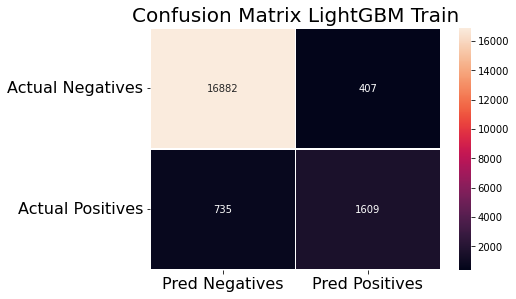

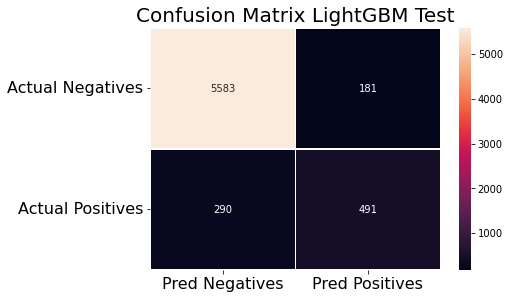

In [ ]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(df_pred_train.delta_WHP_binarized, df_pred_train.delta_WHP_binarized_pred)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(df_pred_test.delta_WHP_binarized,  df_pred_test.delta_WHP_binarized_pred)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

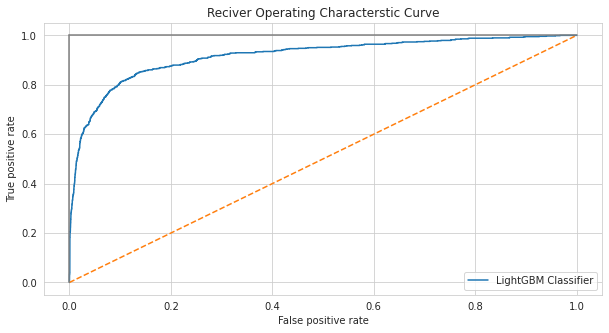

In [ ]:
# Obtencion de predicciones para graficar curva ROC
predsdmodel = df_pred_proba_test[1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(df_pred_proba_test.delta_WHP_binarized,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

In [ ]:
# Curva Precision-Recall
average_precision = average_precision_score(df_pred_proba_test.delta_WHP_binarized, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));

0.7271216430460337


NameError: ignored